# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of fruit & nuts production in Italy 2006-2022
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).

 


In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
fruits_nuts = pd.read_csv('./Italy_crop_data/fruits_crop.csv',skipinitialspace=True)
fruits_nuts.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2006,2006,22,NaN,NaN
1,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2007,2007,10,NaN,NaN
2,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2008,2008,10,NaN,NaN
3,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2009,2009,10,NaN,NaN
4,ITD35,Venezia,PA_EXT,production area - hectares,KIWI,kiwi,2010,2010,9,NaN,NaN


## Pre-processing dataset 

In [3]:
# Drop Columns
fruits_nuts = fruits_nuts.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
fruits_nuts

,Territory,Data type,Type of crop,Select time,Value
0,Venezia,production area - hectares,kiwi,2006,22
1,Venezia,production area - hectares,kiwi,2007,10
2,Venezia,production area - hectares,kiwi,2008,10
3,Venezia,production area - hectares,kiwi,2009,10
4,Venezia,production area - hectares,kiwi,2010,9
...,...,...,...,...,...
86383,Treviso,total area - hectares,sour cherries,2022,15
86384,Padova,total area - hectares,sour cherries,2022,12
86385,Rovigo,total area - hectares,sour cherries,2022,1
86386,Pesaro e Urbino,total area - hectares,sour cherries,2022,3


In [4]:
# Rename Columns
fruits_nuts = fruits_nuts.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(fruits_nuts):
    print('DATASET SHAPE: ', fruits_nuts.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(fruits_nuts.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(fruits_nuts.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(fruits_nuts.isnull().sum())
show_info(fruits_nuts)

DATASET SHAPE:  (86388, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86388 entries, 0 to 86387
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       86388 non-null  object
 1   Data_type  86388 non-null  object
 2   Type_crop  86388 non-null  object
 3   Year       86388 non-null  int64 
 4   Value      86388 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.3+ MB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City           112
Data_type        4
Type_crop       55
Year            17
Value        10222
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing fruits

In [6]:
#fruits_nuts.City.unique()


In [7]:
fruits_nuts.Data_type.unique()

array(['production area - hectares ', 'total area - hectares',
       'harvested production - quintals ', 'total production - quintals '],
      dtype=object)

## Select only values for total fruits production - quintals


In [8]:
fruits_nuts_total_prod = fruits_nuts[fruits_nuts['Data_type'] == 'total production - quintals ']
fruits_nuts_total_prod.head()

,City,Data_type,Type_crop,Year,Value
103,Perugia,total production - quintals,nectarine,2006,2925
104,Perugia,total production - quintals,nectarine,2007,2850
105,Perugia,total production - quintals,nectarine,2008,2800
106,Perugia,total production - quintals,nectarine,2009,2800
107,Perugia,total production - quintals,nectarine,2010,2800


In [9]:
fruits_nuts_total_prod = fruits_nuts_total_prod.rename(columns = {'Value':'Total_production'})
fruits_nuts_total_prod

,City,Data_type,Type_crop,Year,Total_production
103,Perugia,total production - quintals,nectarine,2006,2925
104,Perugia,total production - quintals,nectarine,2007,2850
105,Perugia,total production - quintals,nectarine,2008,2800
106,Perugia,total production - quintals,nectarine,2009,2800
107,Perugia,total production - quintals,nectarine,2010,2800
...,...,...,...,...,...
86348,Nuoro,total production - quintals,citrus fruit,2021,45070
86352,Cagliari,total production - quintals,citrus fruit,2021,5721
86356,Oristano,total production - quintals,citrus fruit,2021,114990
86360,Barletta-Andria-Trani,total production - quintals,citrus fruit,2021,3050


In [10]:
fruits_nuts_total_prod =fruits_nuts_total_prod.drop(columns =['Data_type'])
fruits_nuts_total_prod

,City,Type_crop,Year,Total_production
103,Perugia,nectarine,2006,2925
104,Perugia,nectarine,2007,2850
105,Perugia,nectarine,2008,2800
106,Perugia,nectarine,2009,2800
107,Perugia,nectarine,2010,2800
...,...,...,...,...
86348,Nuoro,citrus fruit,2021,45070
86352,Cagliari,citrus fruit,2021,5721
86356,Oristano,citrus fruit,2021,114990
86360,Barletta-Andria-Trani,citrus fruit,2021,3050


## Total fruit & nuts production in 2006-2022

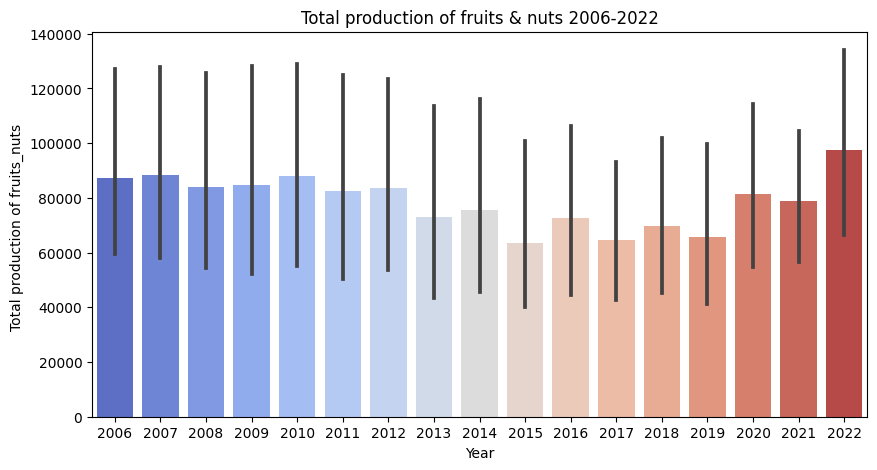

In [12]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Total_production',data = fruits_nuts_total_prod, palette='coolwarm')
plt.title('Total production of fruits & nuts 2006-2022')
plt.xlabel('Year')
plt.ylabel('Total production of fruits_nuts ')
plt.show()



## Fruit production by Cities 

In [14]:
fruits_nuts_total_prod_region = fruits_nuts_total_prod.groupby(by = fruits_nuts_total_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False).head(10)
fruits_nuts_total_prod_region

,City,Total_production
98,Trentino Alto Adige / Südtirol,300309880
14,Bolzano / Bozen,192574949
99,Trento,91029605
26,Cosenza,83242094
21,Caserta,77018018
79,Ravenna,69378496
22,Catania,67014131
108,Verona,63909250
29,Cuneo,63459241
32,Ferrara,56039779


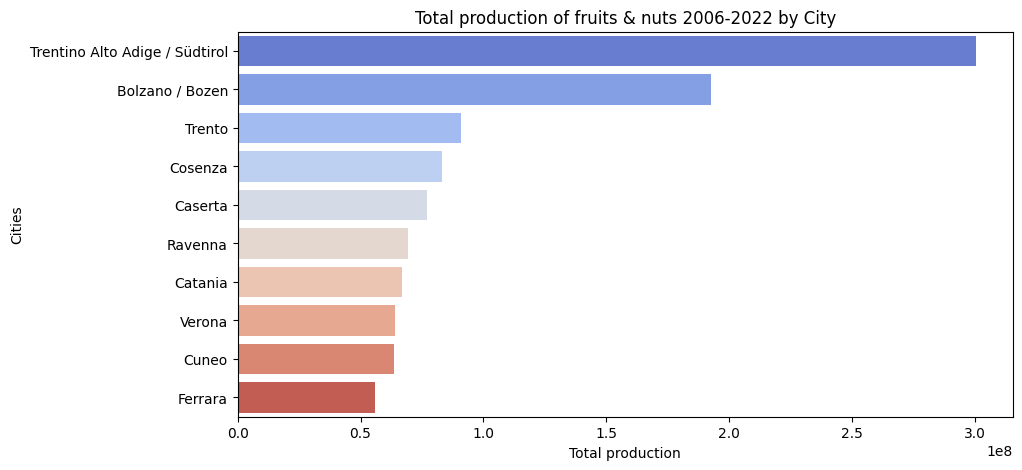

In [15]:
plt.figure(figsize= (10,5))
sns.barplot(x=fruits_nuts_total_prod_region['Total_production'],y= fruits_nuts_total_prod_region['City'], orient='h', palette='coolwarm');
plt.title('Total production of fruits & nuts 2006-2022 by City')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show()

## fruits_nuts produced 2006-2022

In [21]:
print(fruits_nuts_total_prod.Type_crop.max())
print(fruits_nuts_total_prod.Type_crop.value_counts())
print(fruits_nuts_total_prod.Type_crop.nunique())



white oranges (blancas)
pear                                                              1760
apple                                                             1732
peach                                                             1714
apricot                                                           1543
cherry in complex                                                 1506
plum                                                              1494
nectarine                                                         1391
kiwi                                                              1382
hazelnut                                                          1027
almond                                                             711
lemon                                                              672
mandarine                                                          595
fig                                                                583
clementine                                           

Dataset shows there are 55 different types of fruits and nuts cultivated in Italy. The top most produced crops are White oranges, Peach, Pear, Apples, Apricot, Cherry, Plum, Kiwi, Nectarine, Hazelnut, Almond and Raspberry. 

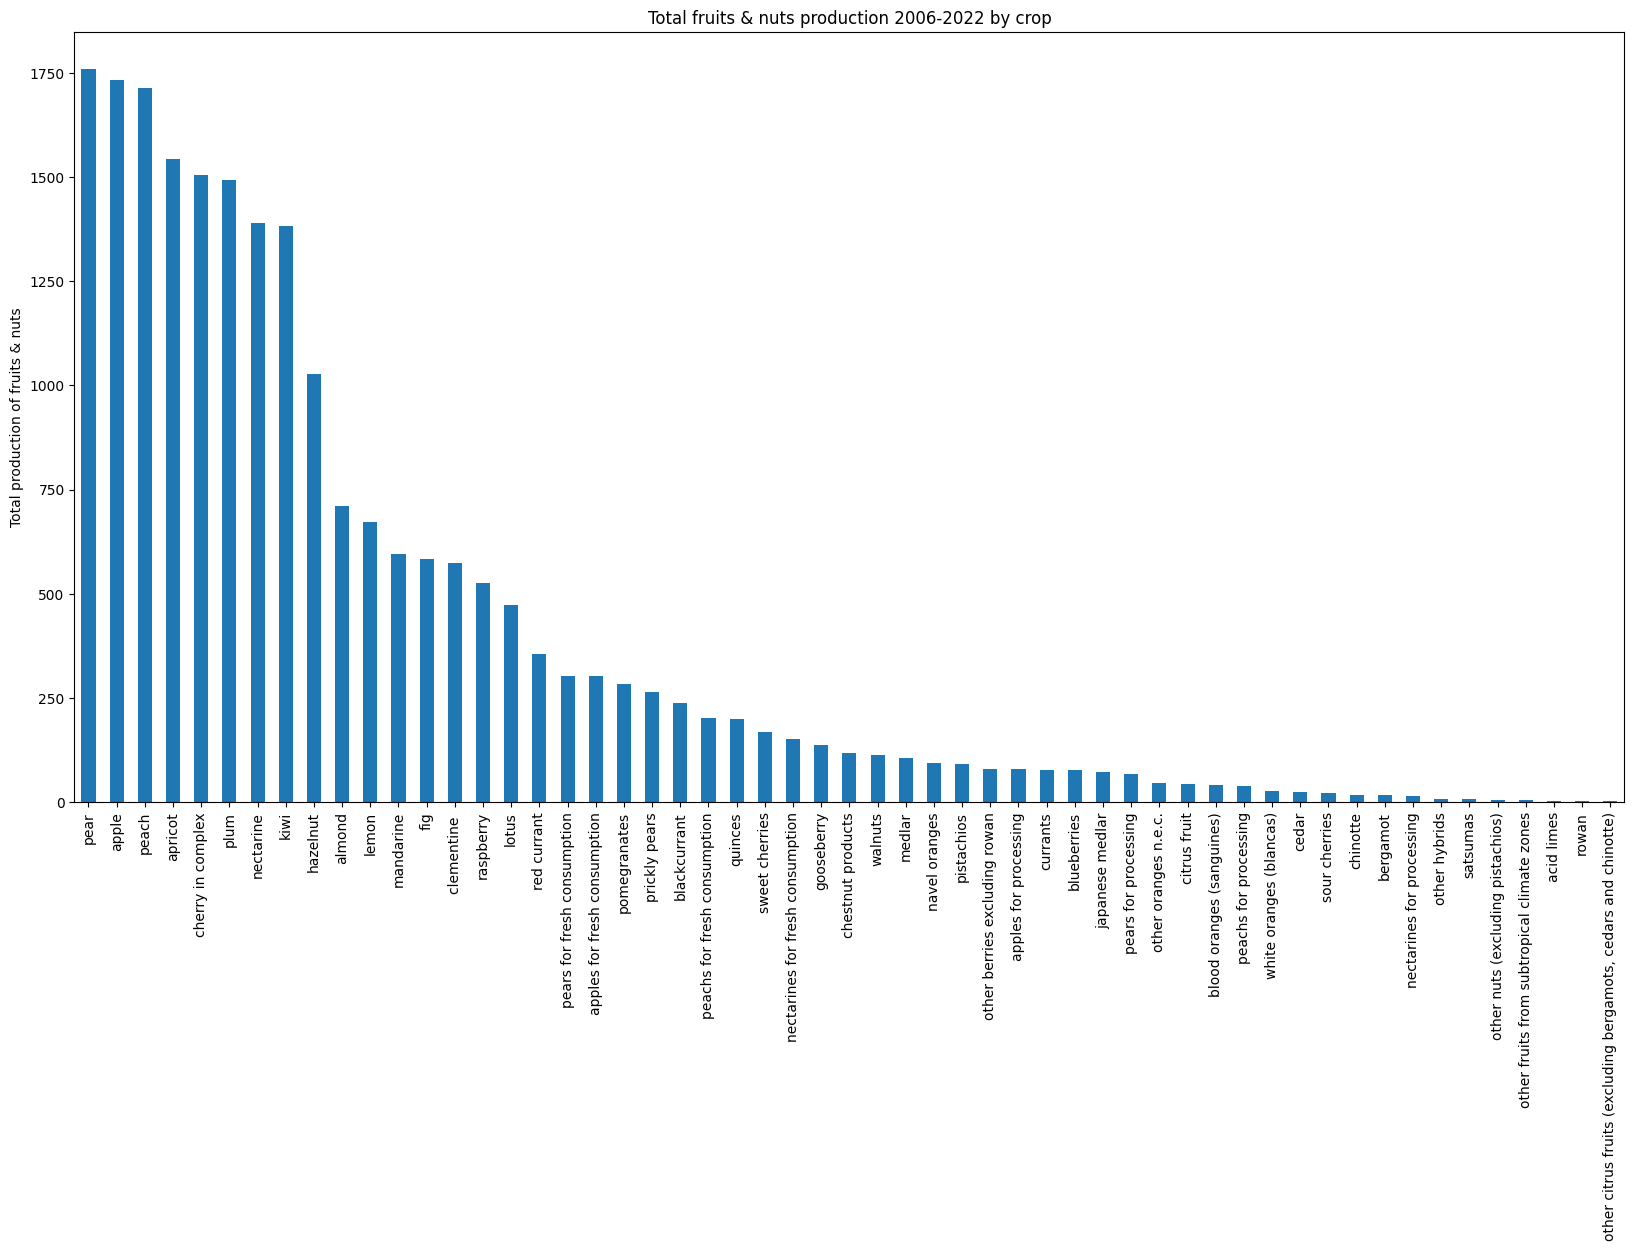

In [22]:
plt.figure(figsize=(20,10))
fruits_nuts_total_prod ['Type_crop'].value_counts().plot.bar()
plt.title('Total fruits & nuts production 2006-2022 by crop')
plt.ylabel('Total production of fruits & nuts')
plt.show()

## Subseting data

In [25]:
fruits_nuts_top10 = fruits_nuts_total_prod.apply(lambda row: row[fruits_nuts_total_prod['Type_crop'].isin(['peach', 'pear', 'apple', 'apricot', 'hazelnut',
                                                                                           'plum', 'kiwi', 'almond', 'cherry in complex','nectarine'])])

fruits_nuts_top10.head()

,City,Type_crop,Year,Total_production
103,Perugia,nectarine,2006,2925
104,Perugia,nectarine,2007,2850
105,Perugia,nectarine,2008,2800
106,Perugia,nectarine,2009,2800
107,Perugia,nectarine,2010,2800


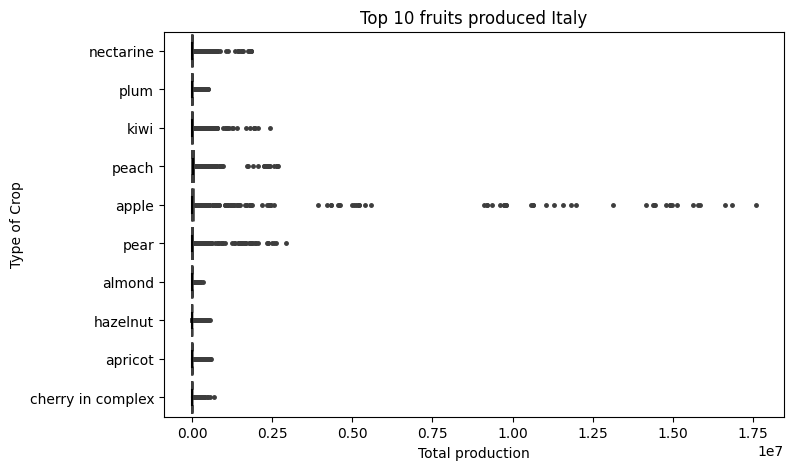

In [26]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=fruits_nuts_top10, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)
plt.title('Top 10 fruits produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

In [27]:
fruits_nuts_top10

,City,Type_crop,Year,Total_production
103,Perugia,nectarine,2006,2925
104,Perugia,nectarine,2007,2850
105,Perugia,nectarine,2008,2800
106,Perugia,nectarine,2009,2800
107,Perugia,nectarine,2010,2800
...,...,...,...,...
77543,Trento,kiwi,2022,9500
77956,Trento,hazelnut,2019,2
77957,Trento,hazelnut,2020,2
77958,Trento,hazelnut,2021,20


## Vizualization of ten type of fruits & nuts produced in Italy in the period of 2006-2022 

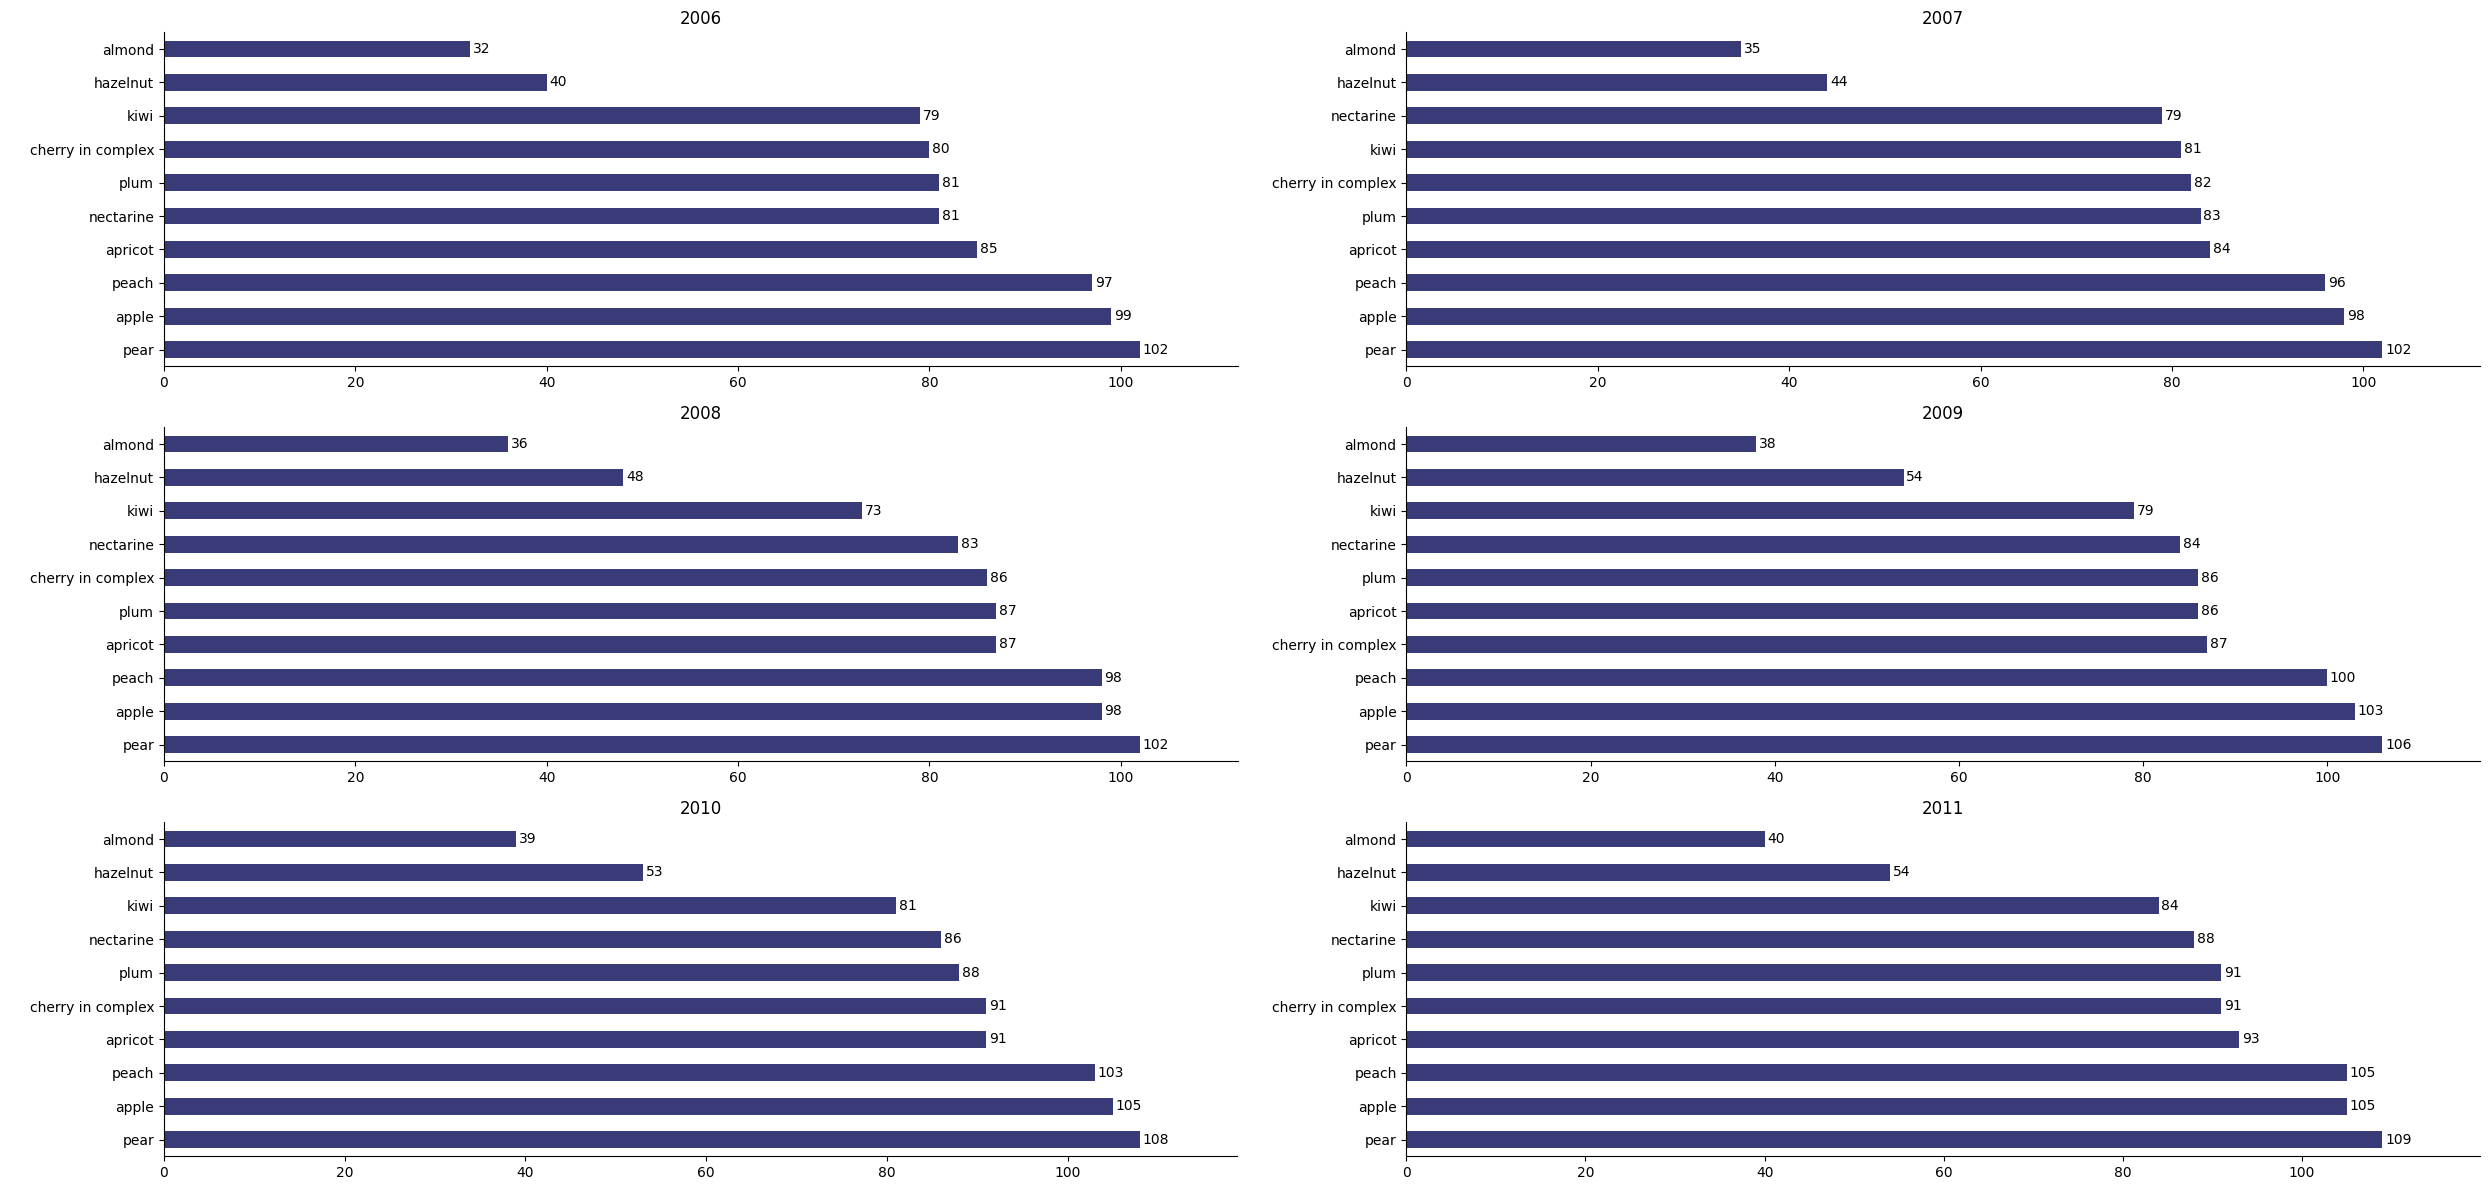

In [28]:
fig, axs = plt.subplots(3,2, figsize=(25, 12))

plot1 = fruits_nuts_top10[fruits_nuts_top10.Year == 2006].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2006', ax=axs[0,0])
plot2 = fruits_nuts_top10[fruits_nuts_top10.Year == 2007].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2007', ax=axs[0,1])
plot3 = fruits_nuts_top10[fruits_nuts_top10.Year == 2008].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2008', ax=axs[1,0])
plot4 = fruits_nuts_top10[fruits_nuts_top10.Year == 2009].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2009', ax=axs[1,1])
plot5 = fruits_nuts_top10[fruits_nuts_top10.Year == 2010].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2010', ax=axs[2,0])
plot6 = fruits_nuts_top10[fruits_nuts_top10.Year == 2011].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2011', ax=axs[2,1])


for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')
sns.despine()
plt.tight_layout()
plt.show()



<function matplotlib.pyplot.show(close=None, block=None)>

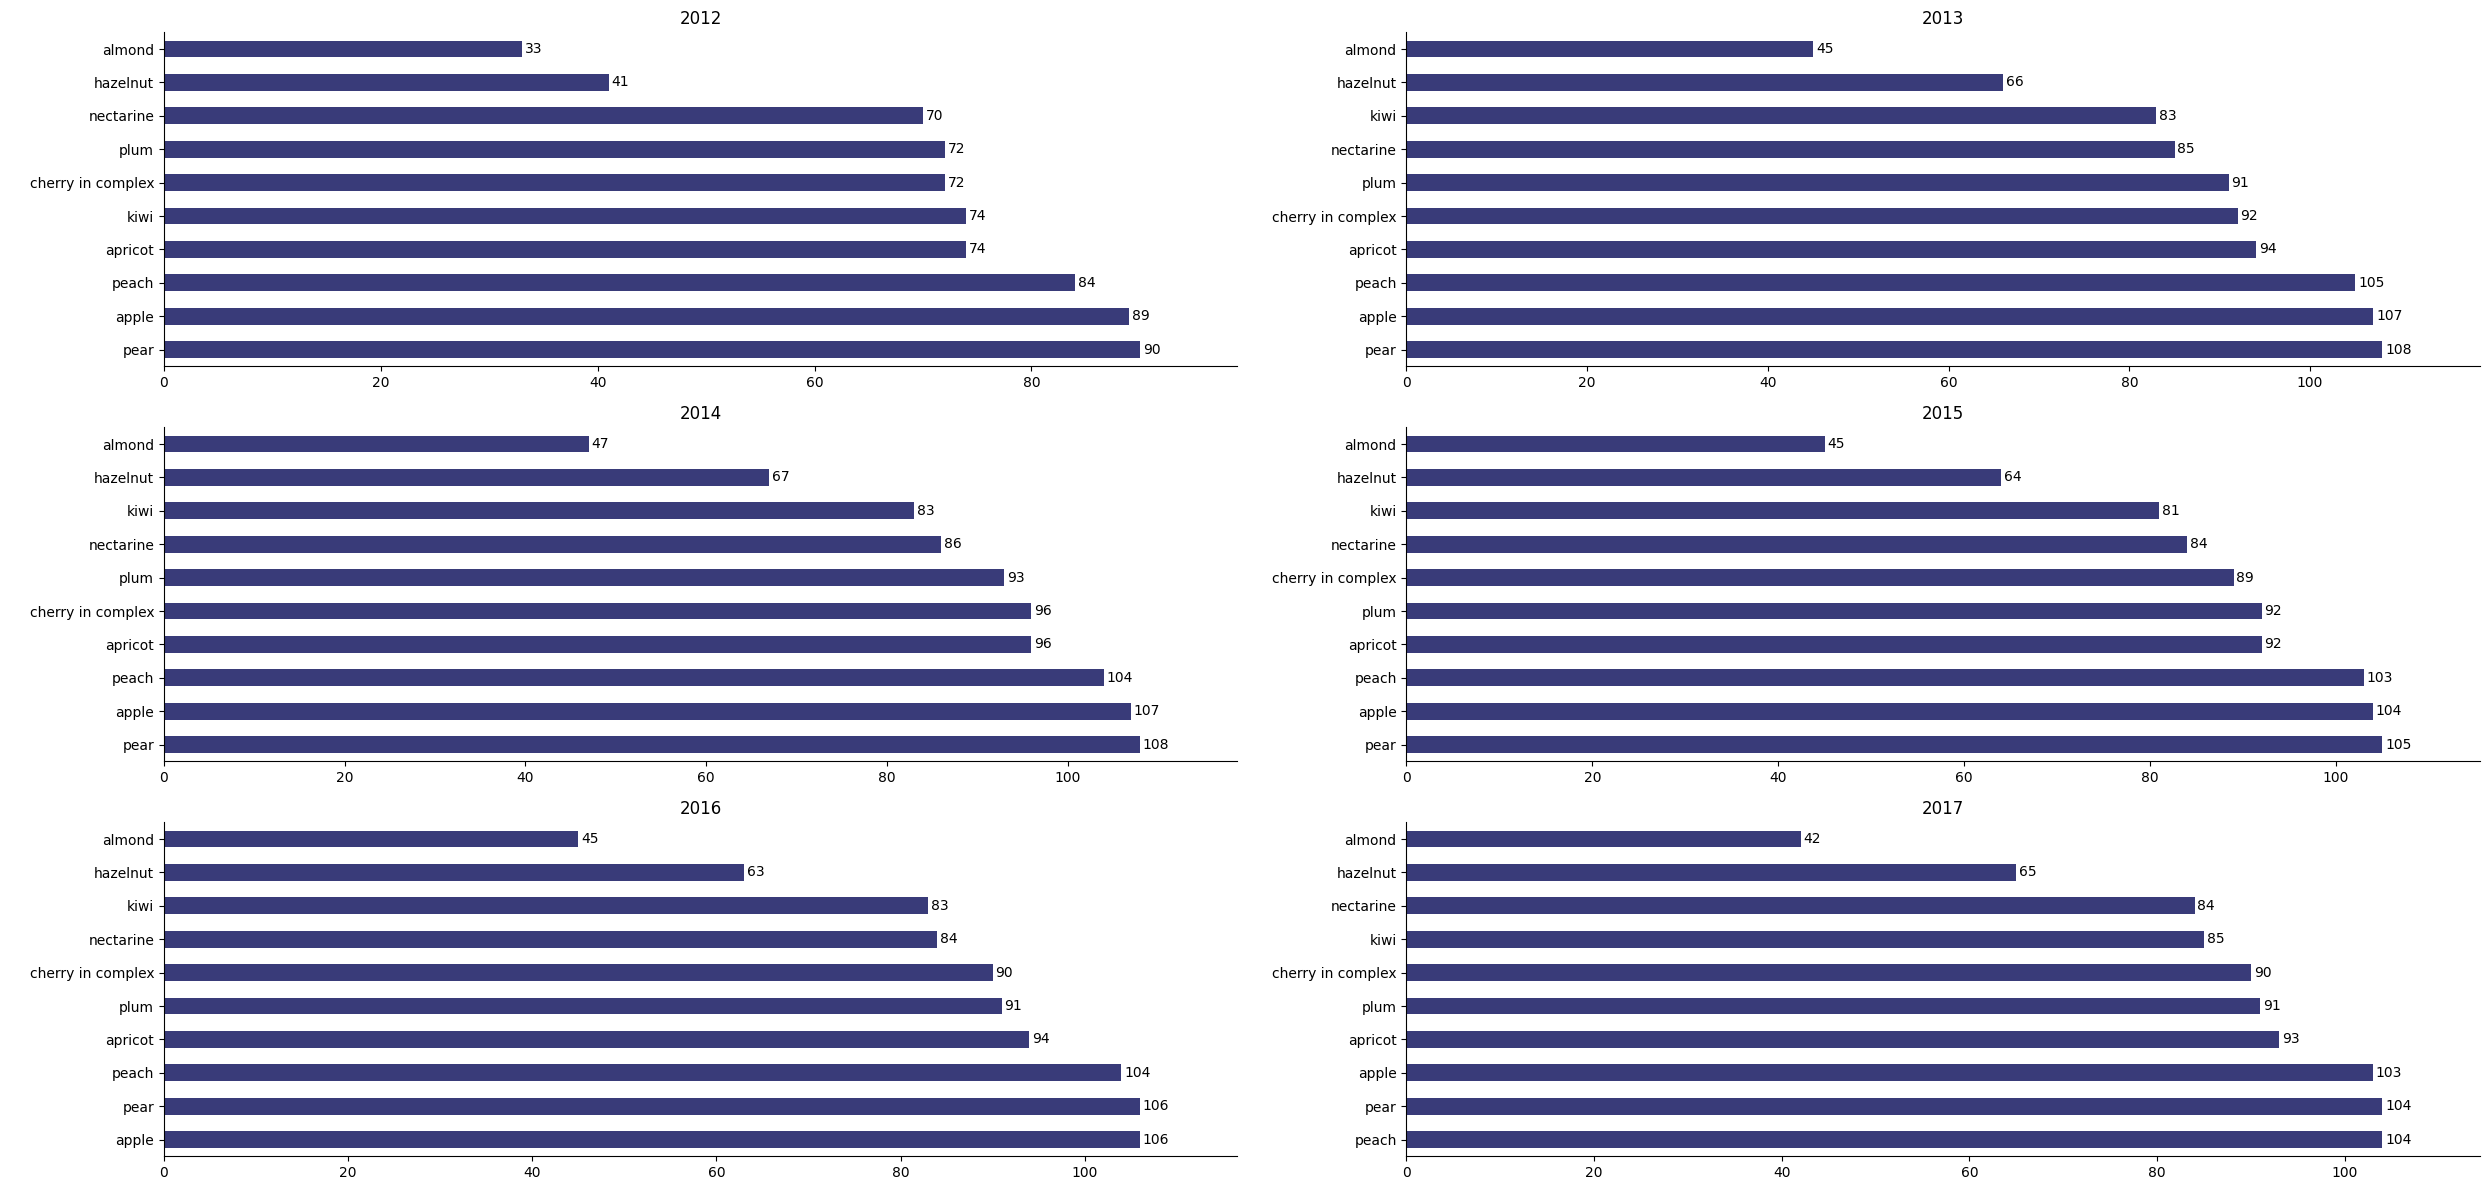

In [29]:
fig, axs = plt.subplots(3,2, figsize=(25, 12))

plot7 =fruits_nuts_top10[fruits_nuts_top10.Year == 2012].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2012', ax=axs[0,0])
plot8 =fruits_nuts_top10[fruits_nuts_top10.Year == 2013].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2013', ax=axs[0,1])
plot9 =fruits_nuts_top10[fruits_nuts_top10.Year == 2014].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2014', ax=axs[1,0])
plot10 =fruits_nuts_top10[fruits_nuts_top10.Year == 2015].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2015', ax=axs[1,1])
plot11 =fruits_nuts_top10[fruits_nuts_top10.Year == 2016].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2016', ax=axs[2,0])
plot12 =fruits_nuts_top10[fruits_nuts_top10.Year == 2017].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2017', ax=axs[2,1])


for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')                                                                                                 
sns.despine()
plt.tight_layout()
plt.show

IndexError: list index out of range

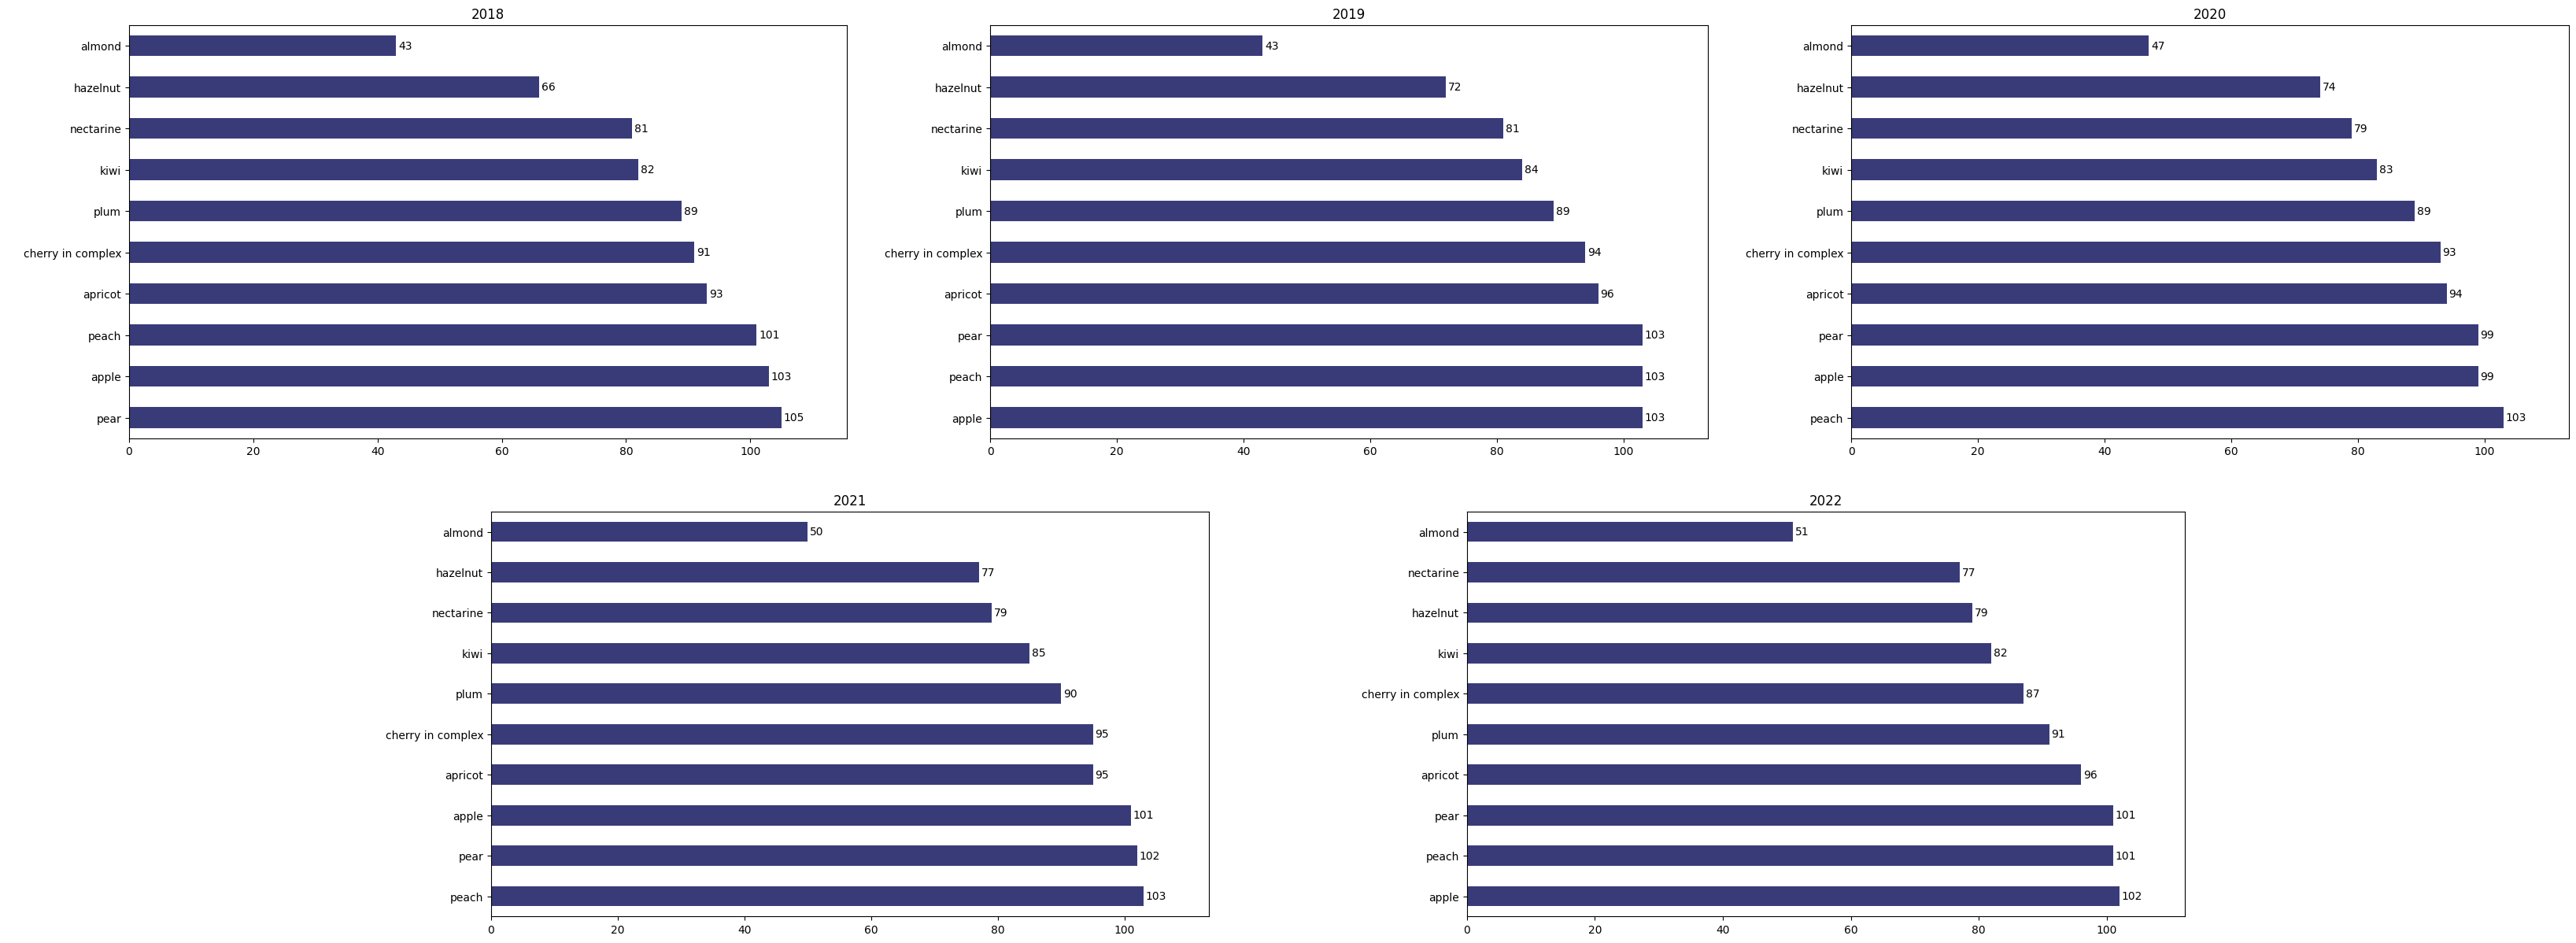

In [30]:
fig, axs = plt.subplots(2,3, figsize=(40,15))

axs[1,0].set_position([0.24,0.125,0.228,0.343])
axs[1,1].set_position([0.55,0.125,0.228,0.343])
axs[1,2].set_visible(False)


plot13 = fruits_nuts_top10[fruits_nuts_top10.Year == 2018].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2018', ax=axs[0,0])
plot14 = fruits_nuts_top10[fruits_nuts_top10.Year == 2019].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2019', ax=axs[0,1])
plot15 = fruits_nuts_top10[fruits_nuts_top10.Year == 2020].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2020', ax=axs[0,2])
plot16 = fruits_nuts_top10[fruits_nuts_top10.Year == 2021].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2021', ax=axs[1,0])
plot17 = fruits_nuts_top10[fruits_nuts_top10.Year == 2022].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2022', ax=axs[1,1])


for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
    ax.set_ylabel(' ')                                                                                                 
sns.despine()
plt.tight_layout()
plt.show

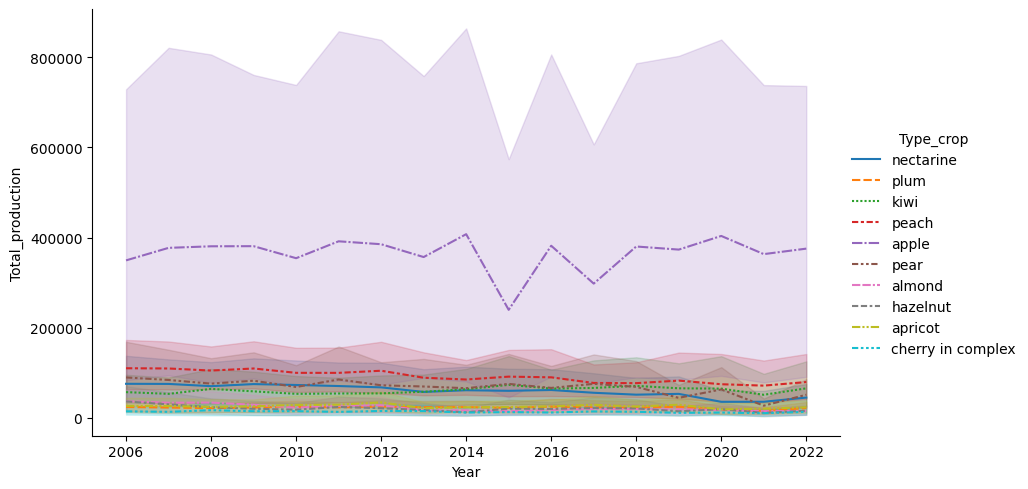

In [31]:
#Crop harvested by year
plotcrop10 = sns.relplot(kind='line', data=fruits_nuts_top10, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


The relplot shows the mean and 95% CI for each crop.

### Create new column for each selected crop produced 

In [32]:
# Create columns for each type of fertilizer 
fruits_nuts_top10_pivot = fruits_nuts_top10.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
fruits_nuts_top10_pivot

Total_production                                                \
Type_crop                almond    apple  apricot cherry in complex  hazelnut   
City      Year                                                                  
Agrigento 2006         267630.0  12920.0  56100.0            3358.0       NaN   
          2007         253352.0  14280.0  54291.0            2603.0       NaN   
          2008         334736.0  14800.0  55605.0            2490.0       NaN   
          2009         249200.0  14970.0  56200.0            2630.0       NaN   
          2010         210400.0  15200.0  57280.0            2950.0       NaN   
...                         ...      ...      ...               ...       ...   
Viterbo   2018              NaN  26500.0   1900.0            8000.0  462000.0   
          2019              NaN  19980.0   1950.0            7500.0  305000.0   
          2020              NaN  20500.0   1980.0            7600.0  340000.0   
          2021           2200.0  20100.0   2200.0            7900.0  250000.0   
          2022           8900.0  21500.0   2150.0            7600.0  290000.0   

                                                                
Type_crop           kiwi nectarine     peach      pear    plum  
City      Year                                                  
Agrigento 2006     564.0   17100.0  417360.0  216640.0  3680.0  
          2007     555.0   16924.0  404400.0  231876.0  4313.0  
          2008       NaN   15980.0  417540.0  230800.0  4048.0  
          2009       NaN   16130.0  436480.0  227800.0  4620.0  
          2010       NaN   16885.0  430340.0  238800.0  4760.0  
...                  ...       ...       ...       ...     ...  
Viterbo   2018   99000.0     285.0   20500.0       NaN  1530.0  
          2019   89000.0     270.0   18900.0     430.0  1440.0  
          2020   79000.0     265.0   17900.0     420.0  1440.0  
          2021   77000.0     190.0   14500.0     405.0  1410.0  
          2022  133700.0     220.0   16000.0     420.0  1440.0  

[1820 rows x 10 columns]

In [33]:
# Drop level
fruits_nuts_top10_pivot.columns = fruits_nuts_top10_pivot.columns.droplevel()
fruits_nuts_top10_pivot

Type_crop         almond    apple  apricot  cherry in complex  hazelnut  \
City      Year                                                            
Agrigento 2006  267630.0  12920.0  56100.0             3358.0       NaN   
          2007  253352.0  14280.0  54291.0             2603.0       NaN   
          2008  334736.0  14800.0  55605.0             2490.0       NaN   
          2009  249200.0  14970.0  56200.0             2630.0       NaN   
          2010  210400.0  15200.0  57280.0             2950.0       NaN   
...                  ...      ...      ...                ...       ...   
Viterbo   2018       NaN  26500.0   1900.0             8000.0  462000.0   
          2019       NaN  19980.0   1950.0             7500.0  305000.0   
          2020       NaN  20500.0   1980.0             7600.0  340000.0   
          2021    2200.0  20100.0   2200.0             7900.0  250000.0   
          2022    8900.0  21500.0   2150.0             7600.0  290000.0   

Type_crop           kiwi  nectarine     peach      pear    plum  
City      Year                                                   
Agrigento 2006     564.0    17100.0  417360.0  216640.0  3680.0  
          2007     555.0    16924.0  404400.0  231876.0  4313.0  
          2008       NaN    15980.0  417540.0  230800.0  4048.0  
          2009       NaN    16130.0  436480.0  227800.0  4620.0  
          2010       NaN    16885.0  430340.0  238800.0  4760.0  
...                  ...        ...       ...       ...     ...  
Viterbo   2018   99000.0      285.0   20500.0       NaN  1530.0  
          2019   89000.0      270.0   18900.0     430.0  1440.0  
          2020   79000.0      265.0   17900.0     420.0  1440.0  
          2021   77000.0      190.0   14500.0     405.0  1410.0  
          2022  133700.0      220.0   16000.0     420.0  1440.0  

[1820 rows x 10 columns]

In [34]:
fruits_nuts_top10_pivot = fruits_nuts_top10_pivot.fillna(0)
fruits_nuts_top10_pivot

Type_crop         almond    apple  apricot  cherry in complex  hazelnut  \
City      Year                                                            
Agrigento 2006  267630.0  12920.0  56100.0             3358.0       0.0   
          2007  253352.0  14280.0  54291.0             2603.0       0.0   
          2008  334736.0  14800.0  55605.0             2490.0       0.0   
          2009  249200.0  14970.0  56200.0             2630.0       0.0   
          2010  210400.0  15200.0  57280.0             2950.0       0.0   
...                  ...      ...      ...                ...       ...   
Viterbo   2018       0.0  26500.0   1900.0             8000.0  462000.0   
          2019       0.0  19980.0   1950.0             7500.0  305000.0   
          2020       0.0  20500.0   1980.0             7600.0  340000.0   
          2021    2200.0  20100.0   2200.0             7900.0  250000.0   
          2022    8900.0  21500.0   2150.0             7600.0  290000.0   

Type_crop           kiwi  nectarine     peach      pear    plum  
City      Year                                                   
Agrigento 2006     564.0    17100.0  417360.0  216640.0  3680.0  
          2007     555.0    16924.0  404400.0  231876.0  4313.0  
          2008       0.0    15980.0  417540.0  230800.0  4048.0  
          2009       0.0    16130.0  436480.0  227800.0  4620.0  
          2010       0.0    16885.0  430340.0  238800.0  4760.0  
...                  ...        ...       ...       ...     ...  
Viterbo   2018   99000.0      285.0   20500.0       0.0  1530.0  
          2019   89000.0      270.0   18900.0     430.0  1440.0  
          2020   79000.0      265.0   17900.0     420.0  1440.0  
          2021   77000.0      190.0   14500.0     405.0  1410.0  
          2022  133700.0      220.0   16000.0     420.0  1440.0  

[1820 rows x 10 columns]

In [35]:
#Rename index
fruits_nuts_top10_pivot = fruits_nuts_top10_pivot.rename_axis(None,axis=1)
fruits_nuts_top10_pivot

almond    apple  apricot  cherry in complex  hazelnut  \
City      Year                                                            
Agrigento 2006  267630.0  12920.0  56100.0             3358.0       0.0   
          2007  253352.0  14280.0  54291.0             2603.0       0.0   
          2008  334736.0  14800.0  55605.0             2490.0       0.0   
          2009  249200.0  14970.0  56200.0             2630.0       0.0   
          2010  210400.0  15200.0  57280.0             2950.0       0.0   
...                  ...      ...      ...                ...       ...   
Viterbo   2018       0.0  26500.0   1900.0             8000.0  462000.0   
          2019       0.0  19980.0   1950.0             7500.0  305000.0   
          2020       0.0  20500.0   1980.0             7600.0  340000.0   
          2021    2200.0  20100.0   2200.0             7900.0  250000.0   
          2022    8900.0  21500.0   2150.0             7600.0  290000.0   

                    kiwi  nectarine     peach      pear    plum  
City      Year                                                   
Agrigento 2006     564.0    17100.0  417360.0  216640.0  3680.0  
          2007     555.0    16924.0  404400.0  231876.0  4313.0  
          2008       0.0    15980.0  417540.0  230800.0  4048.0  
          2009       0.0    16130.0  436480.0  227800.0  4620.0  
          2010       0.0    16885.0  430340.0  238800.0  4760.0  
...                  ...        ...       ...       ...     ...  
Viterbo   2018   99000.0      285.0   20500.0       0.0  1530.0  
          2019   89000.0      270.0   18900.0     430.0  1440.0  
          2020   79000.0      265.0   17900.0     420.0  1440.0  
          2021   77000.0      190.0   14500.0     405.0  1410.0  
          2022  133700.0      220.0   16000.0     420.0  1440.0  

[1820 rows x 10 columns]

In [36]:
# Reset index
fruits_nuts_top10_pivot = fruits_nuts_top10_pivot.reset_index()
fruits_nuts_top10_pivot

,City,Year,almond,apple,apricot,cherry in complex,hazelnut,kiwi,nectarine,peach,pear,plum
0,Agrigento,2006,267630.0,12920.0,56100.0,3358.0,0.0,564.0,17100.0,417360.0,216640.0,3680.0
1,Agrigento,2007,253352.0,14280.0,54291.0,2603.0,0.0,555.0,16924.0,404400.0,231876.0,4313.0
2,Agrigento,2008,334736.0,14800.0,55605.0,2490.0,0.0,0.0,15980.0,417540.0,230800.0,4048.0
3,Agrigento,2009,249200.0,14970.0,56200.0,2630.0,0.0,0.0,16130.0,436480.0,227800.0,4620.0
4,Agrigento,2010,210400.0,15200.0,57280.0,2950.0,0.0,0.0,16885.0,430340.0,238800.0,4760.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1815,Viterbo,2018,0.0,26500.0,1900.0,8000.0,462000.0,99000.0,285.0,20500.0,0.0,1530.0
1816,Viterbo,2019,0.0,19980.0,1950.0,7500.0,305000.0,89000.0,270.0,18900.0,430.0,1440.0
1817,Viterbo,2020,0.0,20500.0,1980.0,7600.0,340000.0,79000.0,265.0,17900.0,420.0,1440.0
1818,Viterbo,2021,2200.0,20100.0,2200.0,7900.0,250000.0,77000.0,190.0,14500.0,405.0,1410.0


## Estatistical analysis

In [37]:
fruits_nuts_top10_pivot.describe()

,Year,almond,apple,apricot,cherry in complex,hazelnut,kiwi,nectarine,peach,pear,plum
count,1820.000000,1820.000000,1.820000e+03,1820.000000,1820.000000,1820.000000,1.820000e+03,1.820000e+03,1.820000e+03,1.820000e+03,1820.000000
mean,2014.054396,8523.141758,3.468376e+05,21849.583516,11302.580220,11173.363736,4.661280e+04,4.637347e+04,8.613036e+04,6.658452e+04,18743.264286
std,4.880069,31318.690443,1.785767e+06,68436.696706,42088.108401,47375.145346,1.771591e+05,1.714244e+05,2.532980e+05,2.558395e+05,52174.404374
min,2006.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2010.000000,0.000000,2.750000e+03,284.500000,149.750000,0.000000,9.000000e+01,6.750000e+01,2.097500e+03,1.350000e+03,380.000000
50%,2014.000000,0.000000,1.162100e+04,1870.000000,1100.000000,20.000000,1.610000e+03,2.400000e+03,1.414000e+04,6.099000e+03,2555.000000
75%,2018.000000,319.000000,4.662500e+04,9600.000000,6236.250000,563.000000,1.131500e+04,1.260000e+04,4.845825e+04,2.192500e+04,10377.250000
max,2022.000000,334736.000000,1.758828e+07,579305.000000,674000.000000,560000.000000,2.436000e+06,1.853750e+06,2.691160e+06,2.915840e+06,496260.000000


#### Data metrics : skew, kurtosis and mode

In [38]:
fruits_nuts_top10_pivot_stats = fruits_nuts_top10_pivot[['peach', 'pear', 'apple', 'apricot', 'hazelnut','plum', 'kiwi',
                                                     'almond', 'cherry in complex','nectarine']]

print(fruits_nuts_top10_pivot_stats.astype(float).skew())
print(fruits_nuts_top10_pivot_stats.astype(float).kurtosis())
print(fruits_nuts_top10_pivot_stats.astype(float).mode())


peach                7.167509
pear                 6.815790
apple                6.979469
apricot              5.170014
hazelnut             6.504625
plum                 4.875590
kiwi                 7.231580
almond               5.138163
cherry in complex    8.370039
nectarine            6.621302
dtype: float64
peach                61.410389
pear                 52.308276
apple                50.844703
apricot              29.265266
hazelnut             51.302735
plum                 28.292467
kiwi                 66.204441
almond               30.144370
cherry in complex    88.186250
nectarine            52.933304
dtype: float64
   peach  pear  apple  apricot  hazelnut  plum  kiwi  almond  \
0    0.0   0.0    0.0      0.0       0.0   0.0   0.0     0.0   

   cherry in complex  nectarine  
0                0.0        0.0  


### Calculate and print the interquartile range

In [39]:
Q1 = fruits_nuts_top10_pivot_stats.quantile(0.25)
Q3 = fruits_nuts_top10_pivot_stats.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

peach                46360.75
pear                 20575.00
apple                43875.00
apricot               9315.50
hazelnut               563.00
plum                  9997.25
kiwi                 11225.00
almond                 319.00
cherry in complex     6086.50
nectarine            12532.50
dtype: float64


### Remove outliers and plot graphs

In [40]:
# Remove outliers

fruits_nuts_top10_pivot_stats[~((fruits_nuts_top10_pivot_stats < (Q1 - 1.5 * IQR)) | (fruits_nuts_top10_pivot_stats > (Q3 + 1.5 * IQR))).any(axis=1)]

print(fruits_nuts_top10_pivot_stats.shape)

(1820, 10)


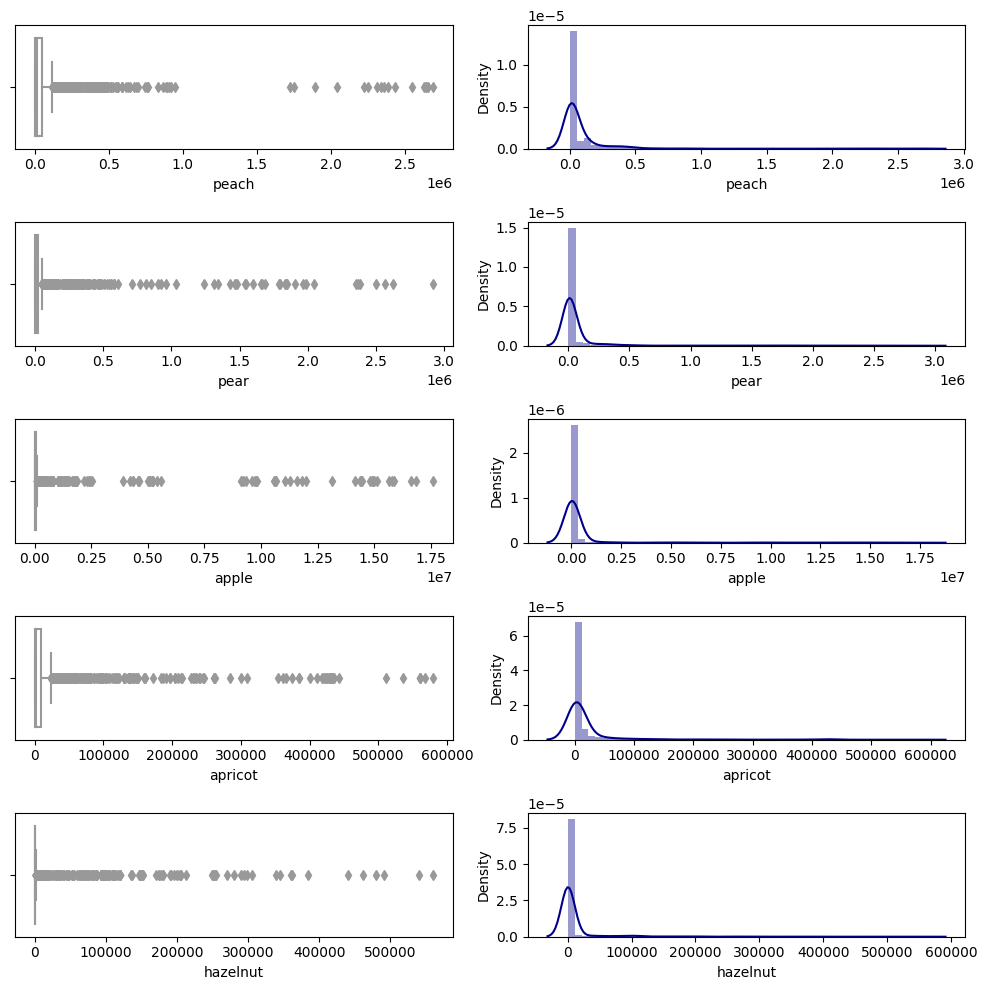

In [41]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= fruits_nuts_top10_pivot_stats["peach"], color = 'white', ax = ax[0,0])
sns.distplot(fruits_nuts_top10_pivot_stats['peach'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["pear"],color = 'white', ax = ax[1,0])
sns.distplot(fruits_nuts_top10_pivot_stats['pear'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["apple"],color = 'white', ax = ax[2,0])
sns.distplot(fruits_nuts_top10_pivot_stats['apple'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["apricot"], color = 'white', ax = ax[3,0])
sns.distplot(fruits_nuts_top10_pivot_stats['apricot'], color = 'darkblue', ax = ax[3,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["hazelnut"], color = 'white',ax = ax[4,0])
sns.distplot(fruits_nuts_top10_pivot_stats['hazelnut'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

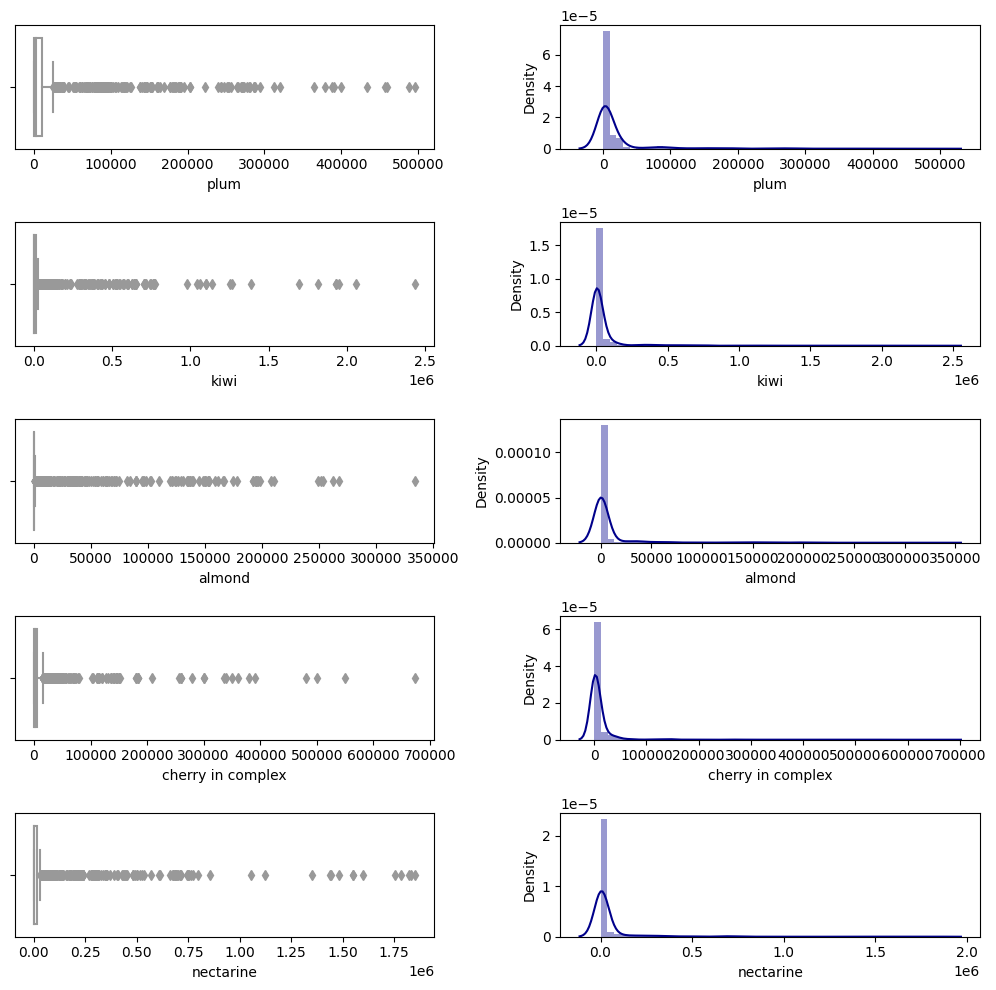

In [42]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= fruits_nuts_top10_pivot_stats["plum"], color = 'white', ax = ax[0,0])
sns.distplot(fruits_nuts_top10_pivot_stats['plum'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["kiwi"],color = 'white', ax = ax[1,0])
sns.distplot(fruits_nuts_top10_pivot_stats['kiwi'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["almond"],color = 'white', ax = ax[2,0])
sns.distplot(fruits_nuts_top10_pivot_stats['almond'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["cherry in complex"], color = 'white',ax = ax[3,0])
sns.distplot(fruits_nuts_top10_pivot_stats['cherry in complex'], color = 'darkblue',ax = ax[3,1])
sns.boxplot(x= fruits_nuts_top10_pivot_stats["nectarine"], color = 'white',ax = ax[4,0])
sns.distplot(fruits_nuts_top10_pivot_stats['nectarine'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

### Pre-processing fertilizer dataset 

In [44]:
fertilizer = pd.read_csv('fertilizer_by_prov.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2006,2006,1227,NaN,NaN
1,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2007,2007,1812,NaN,NaN
2,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2008,2008,5224,NaN,NaN
3,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2009,2009,2051,NaN,NaN
4,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2010,2010,54,NaN,NaN


In [45]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [46]:
#fertilizer.Territory.unique()

In [47]:
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [48]:
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,1227
1,Torino,calcium cyanamide,2007,1812
2,Torino,calcium cyanamide,2008,5224
3,Torino,calcium cyanamide,2009,2051
4,Torino,calcium cyanamide,2010,54
...,...,...,...,...
68381,Sud Sardegna,specific action products -,2017,335
68382,Sud Sardegna,specific action products -,2018,137
68383,Sud Sardegna,specific action products -,2019,164
68384,Sud Sardegna,specific action products -,2020,135


## Select fertilizers 

In [49]:
fertilizer.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrates ', 'ammonium sulphate', 'urea',
       'other fertilizers different from calcium cyanamide, nitrates, ammonium sulphate, urea',
       'simple superphosphate', 'triple superphosphate',
       'other fertilizers different from simple superphosphate and triple superphosphate',
       'sulphate', 'chloride ',
       'other fertilizers different from sulphate and chloride ',
       'two components - nitrogen-phosphorous',
       'two components - phosphorus-potassium',
       'two components - nitrogen-potassium',
       'three components - nitrogen-phosphorous-phosphorous',
       'containing only one secondary macronutrient - calcium oxide',
       'containing only one secondary macronutrient - magnesium oxide',
       'containing only one secondary macronutrient - sulphur oxide',
       'containing only one secondary macronutrient',
       'containing micronutrients containing only a micronutrient in mineral form',
       'containing micronutrients 

In [50]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())
print(fertilizer.Type_fertilizer.nunique())

vegetable soil amendment
specific action products -                                                               3497
three components - nitrogen-phosphorous-phosphorous                                      1941
containing only one secondary macronutrient - magnesium oxide                            1749
soil correctives - other  soil correctives                                               1749
other soil amendments                                                                    1749
peaty soil amendment                                                                     1749
mixed soil amendment                                                                     1749
vegetable soil amendment                                                                 1749
organic-mineral fertilizers - compound                                                   1749
organic-mineral fertilizers - straight nitrogen                                          1749
organic fertilizers - compound     

In [51]:
# Rename name of fertilizers 
fertilizer = fertilizer.replace('organic fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - compound','organic-mineral')
fertilizer = fertilizer.replace('organic fertilizers - compound','organic')
fertilizer = fertilizer.replace('mixed soil amendment','mix-amend')
fertilizer = fertilizer.replace('peaty soil amendment','peaty-amend')
fertilizer = fertilizer.replace('peaty amendment','peaty-amend')
fertilizer = fertilizer.replace('peat amendment','peaty-amend')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - nitrogen-potassium','nitrogen-potassium')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - phosphorus-potassium','phosphorus-potassium')
fertilizer = fertilizer.replace('vegetable soil amendment', 'organic')

In [52]:
fertilizer = fertilizer.apply(lambda row: row[fertilizer['Type_fertilizer'].isin(['calcium cyanamide ','nitrates','organic', 'urea','nitrogen-potassium',
                                                                                  'phosphorus-potassium','ammonium sulphate','calcium cyanamide', 
                                                                                  'nitrogen-phosphorous','peaty-amend','organic-nitrogen' ])])

fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,1227
1,Torino,calcium cyanamide,2007,1812
2,Torino,calcium cyanamide,2008,5224
3,Torino,calcium cyanamide,2009,2051
4,Torino,calcium cyanamide,2010,54


<AxesSubplot: >

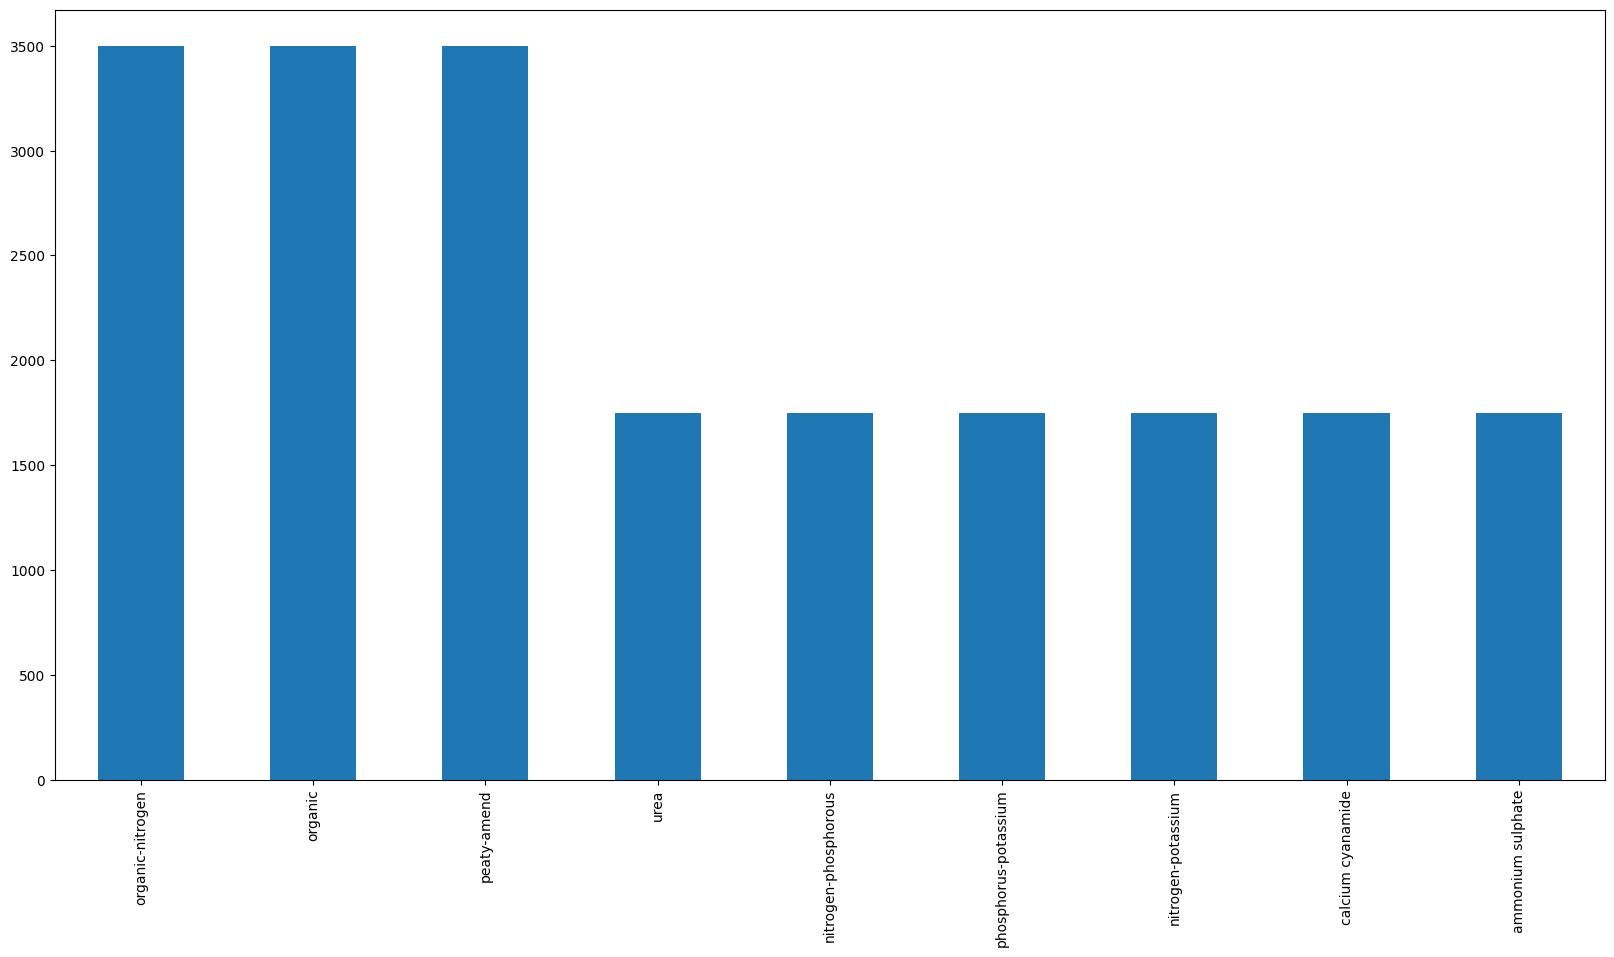

In [53]:
plt.figure(figsize=(20,10))
fertilizer['Type_fertilizer'].value_counts().plot.bar()

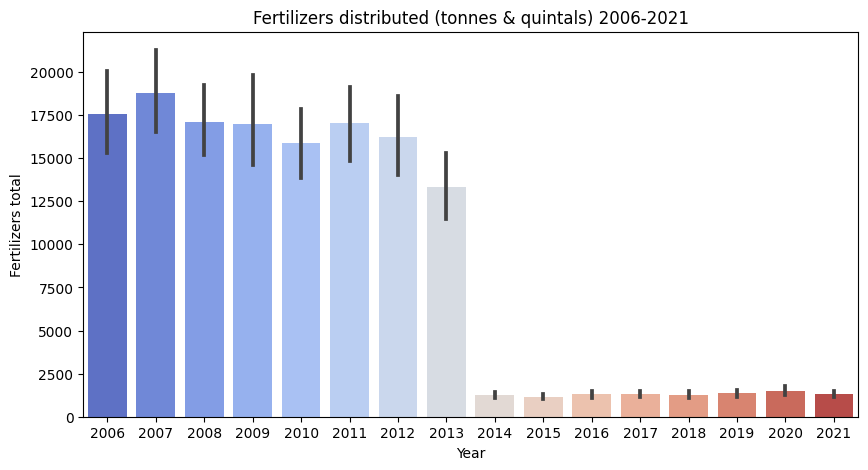

In [54]:
# fertilizer distributed tonnes and quintals
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Fertilizers_tonnes',data = fertilizer, palette='coolwarm')
plt.title('Fertilizers distributed (tonnes & quintals) 2006-2021')
plt.xlabel('Year')
plt.ylabel('Fertilizers total')
plt.show()


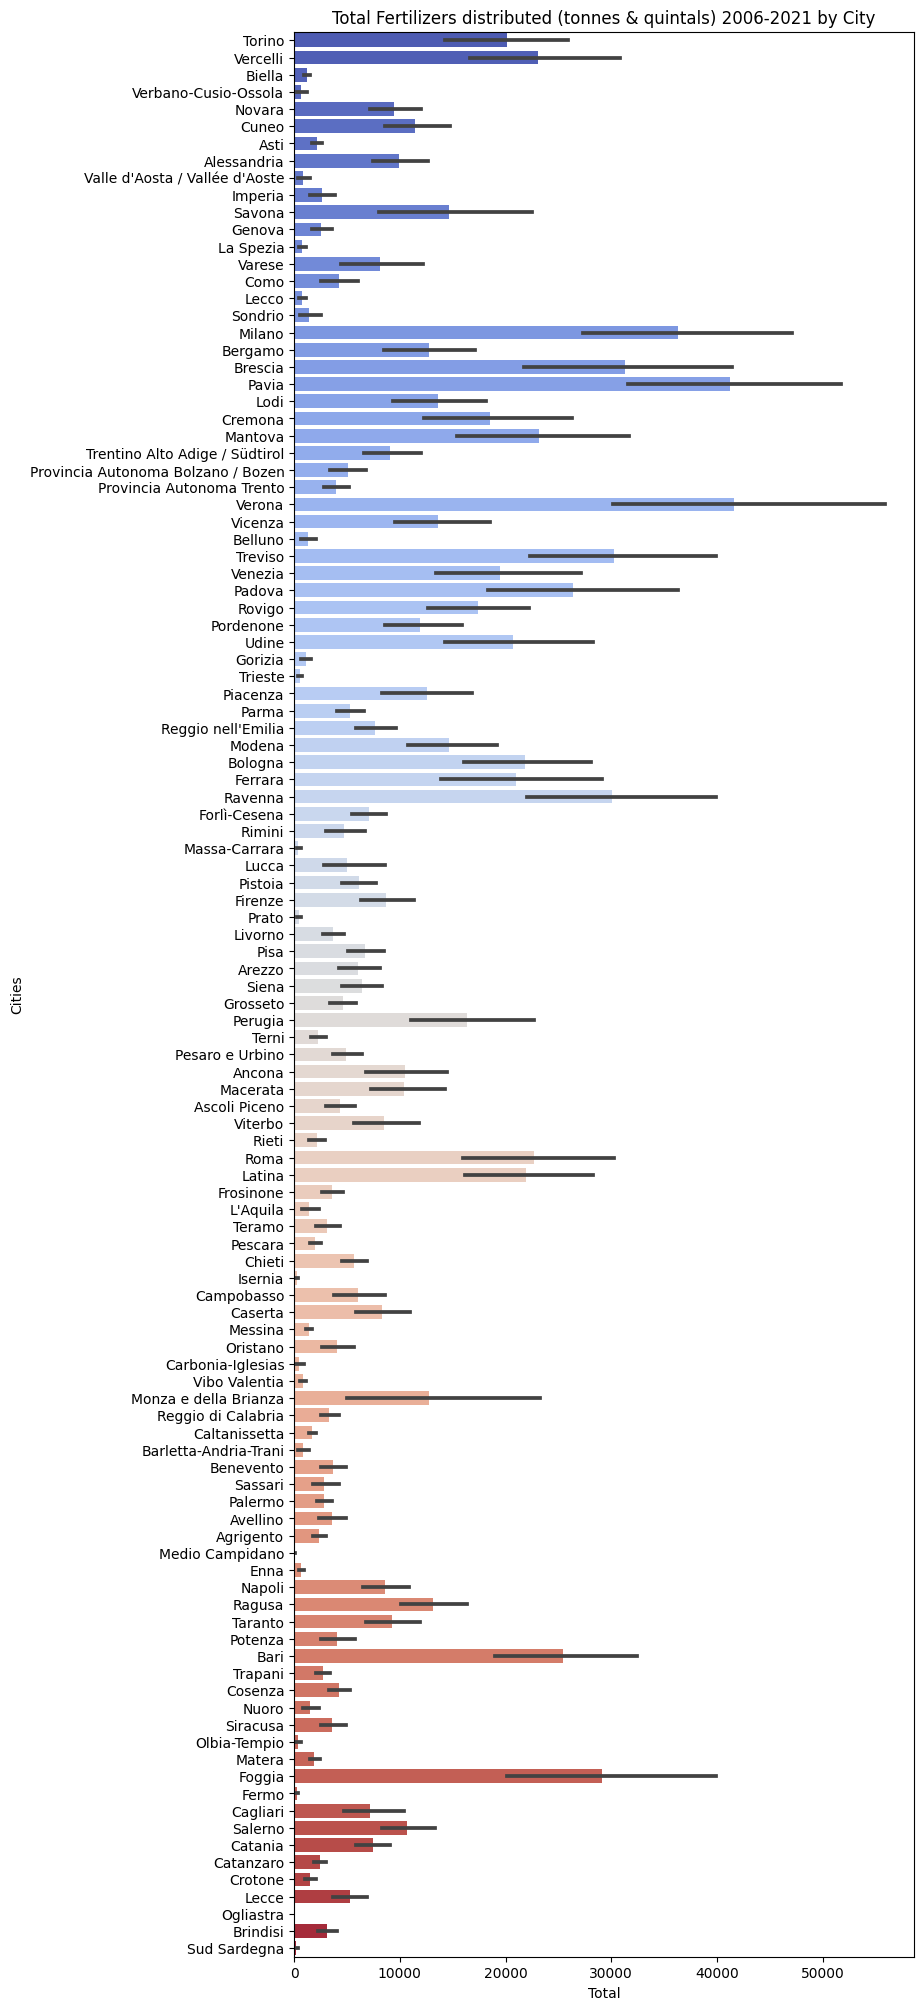

In [55]:
plt.figure(figsize= (8,25))
sns.barplot(x=fertilizer['Fertilizers_tonnes'],y= fertilizer['City'], orient='h', palette='coolwarm');
plt.title('Total Fertilizers distributed (tonnes & quintals) 2006-2021 by City')
plt.xlabel('Total')
plt.ylabel('Cities')
plt.show()

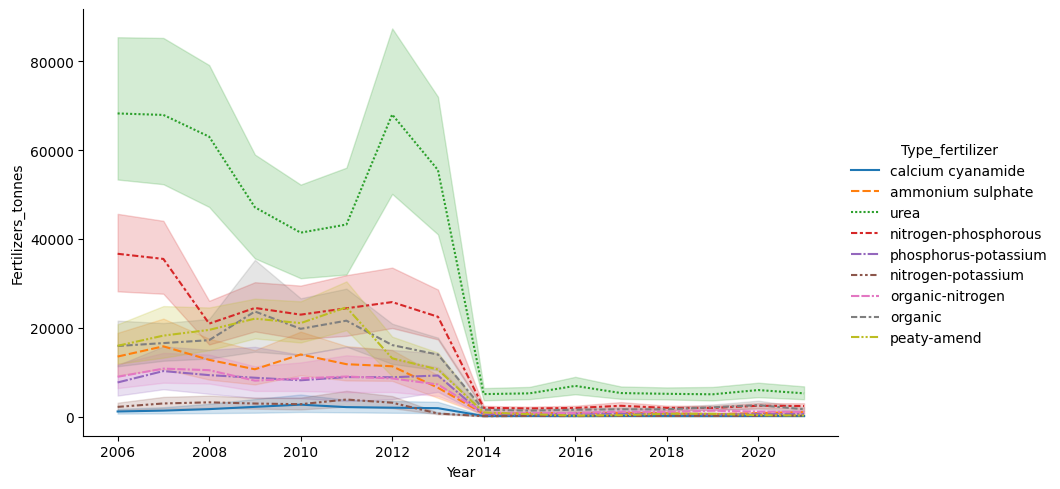

In [56]:
#Fertilizers distributed by year

fertilizer_plot = sns.relplot(kind='line', data=fertilizer, x='Year', y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)


In [57]:
# Create columns for each type of fertilizer 
fertilizer_pivot = fertilizer.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer_pivot

Fertilizers_tonnes                                         \
Type_fertilizer  ammonium sulphate calcium cyanamide nitrogen-phosphorous   
City      Year                                                              
Agrigento 2006              1687.0               0.0               4977.0   
          2007              2171.0               0.0               6498.0   
          2008              1400.0               0.0               5213.0   
          2009              1404.0               0.0               3808.0   
          2010              1416.0             140.0               3271.0   
...                            ...               ...                  ...   
Viterbo   2017               153.0               0.0               4732.0   
          2018               149.0               0.0               4376.0   
          2019                70.0               0.0               3964.0   
          2020               176.0               0.0               6145.0   
          2021               152.0               0.0               3946.0   

                                                                          \
Type_fertilizer nitrogen-potassium  organic organic-nitrogen peaty-amend   
City      Year                                                             
Agrigento 2006               277.0  31439.0           7779.0      2966.0   
          2007               491.0  35348.0           6079.0      2949.0   
          2008               614.0  37504.0          14075.0      3506.0   
          2009               468.0  27914.0           8984.0      5678.0   
          2010               440.0  23460.0           9136.0      3082.0   
...                            ...      ...              ...         ...   
Viterbo   2017                66.0   1760.0           2268.0       274.0   
          2018                19.0   1591.0           2106.0       811.0   
          2019               195.0   1251.0           2884.0       427.0   
          2020                98.0   1236.0           2935.0       275.0   
          2021               112.0   1056.0           3337.0       131.0   

                                              
Type_fertilizer phosphorus-potassium    urea  
City      Year                                
Agrigento 2006                2093.0  2100.0  
          2007                2953.0  5100.0  
          2008                4438.0  2736.0  
          2009                3590.0  2716.0  
          2010                3506.0  2962.0  
...                              ...     ...  
Viterbo   2017                 179.0  2859.0  
          2018                  91.0  2863.0  
          2019                  95.0  2413.0  
          2020                 119.0  3578.0  
          2021                 126.0  2054.0  

[1749 rows x 9 columns]

In [58]:
# Drop level
fertilizer_pivot.columns = fertilizer_pivot.columns.droplevel()
fertilizer_pivot

Type_fertilizer  ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                                
Agrigento 2006              1687.0                0.0                4977.0   
          2007              2171.0                0.0                6498.0   
          2008              1400.0                0.0                5213.0   
          2009              1404.0                0.0                3808.0   
          2010              1416.0              140.0                3271.0   
...                            ...                ...                   ...   
Viterbo   2017               153.0                0.0                4732.0   
          2018               149.0                0.0                4376.0   
          2019                70.0                0.0                3964.0   
          2020               176.0                0.0                6145.0   
          2021               152.0                0.0                3946.0   

Type_fertilizer  nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                                
Agrigento 2006                277.0  31439.0            7779.0       2966.0   
          2007                491.0  35348.0            6079.0       2949.0   
          2008                614.0  37504.0           14075.0       3506.0   
          2009                468.0  27914.0            8984.0       5678.0   
          2010                440.0  23460.0            9136.0       3082.0   
...                             ...      ...               ...          ...   
Viterbo   2017                 66.0   1760.0            2268.0        274.0   
          2018                 19.0   1591.0            2106.0        811.0   
          2019                195.0   1251.0            2884.0        427.0   
          2020                 98.0   1236.0            2935.0        275.0   
          2021                112.0   1056.0            3337.0        131.0   

Type_fertilizer  phosphorus-potassium    urea  
City      Year                                 
Agrigento 2006                 2093.0  2100.0  
          2007                 2953.0  5100.0  
          2008                 4438.0  2736.0  
          2009                 3590.0  2716.0  
          2010                 3506.0  2962.0  
...                               ...     ...  
Viterbo   2017                  179.0  2859.0  
          2018                   91.0  2863.0  
          2019                   95.0  2413.0  
          2020                  119.0  3578.0  
          2021                  126.0  2054.0  

[1749 rows x 9 columns]

In [59]:
#Rename index
fertilizer_pivot = fertilizer_pivot.rename_axis(None,axis=1)
fertilizer_pivot

ammonium sulphate  calcium cyanamide  nitrogen-phosphorous  \
City      Year                                                               
Agrigento 2006             1687.0                0.0                4977.0   
          2007             2171.0                0.0                6498.0   
          2008             1400.0                0.0                5213.0   
          2009             1404.0                0.0                3808.0   
          2010             1416.0              140.0                3271.0   
...                           ...                ...                   ...   
Viterbo   2017              153.0                0.0                4732.0   
          2018              149.0                0.0                4376.0   
          2019               70.0                0.0                3964.0   
          2020              176.0                0.0                6145.0   
          2021              152.0                0.0                3946.0   

                nitrogen-potassium  organic  organic-nitrogen  peaty-amend  \
City      Year                                                               
Agrigento 2006               277.0  31439.0            7779.0       2966.0   
          2007               491.0  35348.0            6079.0       2949.0   
          2008               614.0  37504.0           14075.0       3506.0   
          2009               468.0  27914.0            8984.0       5678.0   
          2010               440.0  23460.0            9136.0       3082.0   
...                            ...      ...               ...          ...   
Viterbo   2017                66.0   1760.0            2268.0        274.0   
          2018                19.0   1591.0            2106.0        811.0   
          2019               195.0   1251.0            2884.0        427.0   
          2020                98.0   1236.0            2935.0        275.0   
          2021               112.0   1056.0            3337.0        131.0   

                phosphorus-potassium    urea  
City      Year                                
Agrigento 2006                2093.0  2100.0  
          2007                2953.0  5100.0  
          2008                4438.0  2736.0  
          2009                3590.0  2716.0  
          2010                3506.0  2962.0  
...                              ...     ...  
Viterbo   2017                 179.0  2859.0  
          2018                  91.0  2863.0  
          2019                  95.0  2413.0  
          2020                 119.0  3578.0  
          2021                 126.0  2054.0  

[1749 rows x 9 columns]

In [60]:
# Reset index
fertilizer_pivot = fertilizer_pivot.reset_index()
fertilizer_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2006,1687.0,0.0,4977.0,277.0,31439.0,7779.0,2966.0,2093.0,2100.0
1,Agrigento,2007,2171.0,0.0,6498.0,491.0,35348.0,6079.0,2949.0,2953.0,5100.0
2,Agrigento,2008,1400.0,0.0,5213.0,614.0,37504.0,14075.0,3506.0,4438.0,2736.0
3,Agrigento,2009,1404.0,0.0,3808.0,468.0,27914.0,8984.0,5678.0,3590.0,2716.0
4,Agrigento,2010,1416.0,140.0,3271.0,440.0,23460.0,9136.0,3082.0,3506.0,2962.0
...,...,...,...,...,...,...,...,...,...,...,...
1744,Viterbo,2017,153.0,0.0,4732.0,66.0,1760.0,2268.0,274.0,179.0,2859.0
1745,Viterbo,2018,149.0,0.0,4376.0,19.0,1591.0,2106.0,811.0,91.0,2863.0
1746,Viterbo,2019,70.0,0.0,3964.0,195.0,1251.0,2884.0,427.0,95.0,2413.0
1747,Viterbo,2020,176.0,0.0,6145.0,98.0,1236.0,2935.0,275.0,119.0,3578.0


In [61]:
# Join both datasets 
it_crop_ferlizer = pd.merge(fruits_nuts_top10_pivot, fertilizer_pivot, on=['Year', 'City'], how='left').fillna(0)
it_crop_ferlizer


,City,Year,almond,apple,apricot,cherry in complex,hazelnut,kiwi,nectarine,peach,...,plum,ammonium sulphate,calcium cyanamide,nitrogen-phosphorous,nitrogen-potassium,organic,organic-nitrogen,peaty-amend,phosphorus-potassium,urea
0,Agrigento,2006,267630.0,12920.0,56100.0,3358.0,0.0,564.0,17100.0,417360.0,...,3680.0,1687.0,0.0,4977.0,277.0,31439.0,7779.0,2966.0,2093.0,2100.0
1,Agrigento,2007,253352.0,14280.0,54291.0,2603.0,0.0,555.0,16924.0,404400.0,...,4313.0,2171.0,0.0,6498.0,491.0,35348.0,6079.0,2949.0,2953.0,5100.0
2,Agrigento,2008,334736.0,14800.0,55605.0,2490.0,0.0,0.0,15980.0,417540.0,...,4048.0,1400.0,0.0,5213.0,614.0,37504.0,14075.0,3506.0,4438.0,2736.0
3,Agrigento,2009,249200.0,14970.0,56200.0,2630.0,0.0,0.0,16130.0,436480.0,...,4620.0,1404.0,0.0,3808.0,468.0,27914.0,8984.0,5678.0,3590.0,2716.0
4,Agrigento,2010,210400.0,15200.0,57280.0,2950.0,0.0,0.0,16885.0,430340.0,...,4760.0,1416.0,140.0,3271.0,440.0,23460.0,9136.0,3082.0,3506.0,2962.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,Viterbo,2018,0.0,26500.0,1900.0,8000.0,462000.0,99000.0,285.0,20500.0,...,1530.0,149.0,0.0,4376.0,19.0,1591.0,2106.0,811.0,91.0,2863.0
1816,Viterbo,2019,0.0,19980.0,1950.0,7500.0,305000.0,89000.0,270.0,18900.0,...,1440.0,70.0,0.0,3964.0,195.0,1251.0,2884.0,427.0,95.0,2413.0
1817,Viterbo,2020,0.0,20500.0,1980.0,7600.0,340000.0,79000.0,265.0,17900.0,...,1440.0,176.0,0.0,6145.0,98.0,1236.0,2935.0,275.0,119.0,3578.0
1818,Viterbo,2021,2200.0,20100.0,2200.0,7900.0,250000.0,77000.0,190.0,14500.0,...,1410.0,152.0,0.0,3946.0,112.0,1056.0,3337.0,131.0,126.0,2054.0


## Correlation 

In [62]:

crop = it_crop_ferlizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer[['peach', 'pear', 'apple', 'apricot', 'hazelnut','plum', 
                                 'kiwi','almond', 'cherry in complex','nectarine',
                                  'calcium cyanamide','organic', 'urea','nitrogen-potassium',
                                  'phosphorus-potassium','ammonium sulphate','calcium cyanamide', 
                                  'nitrogen-phosphorous','peaty-amend','organic-nitrogen']] 



<AxesSubplot: title={'center': 'Correlation'}>

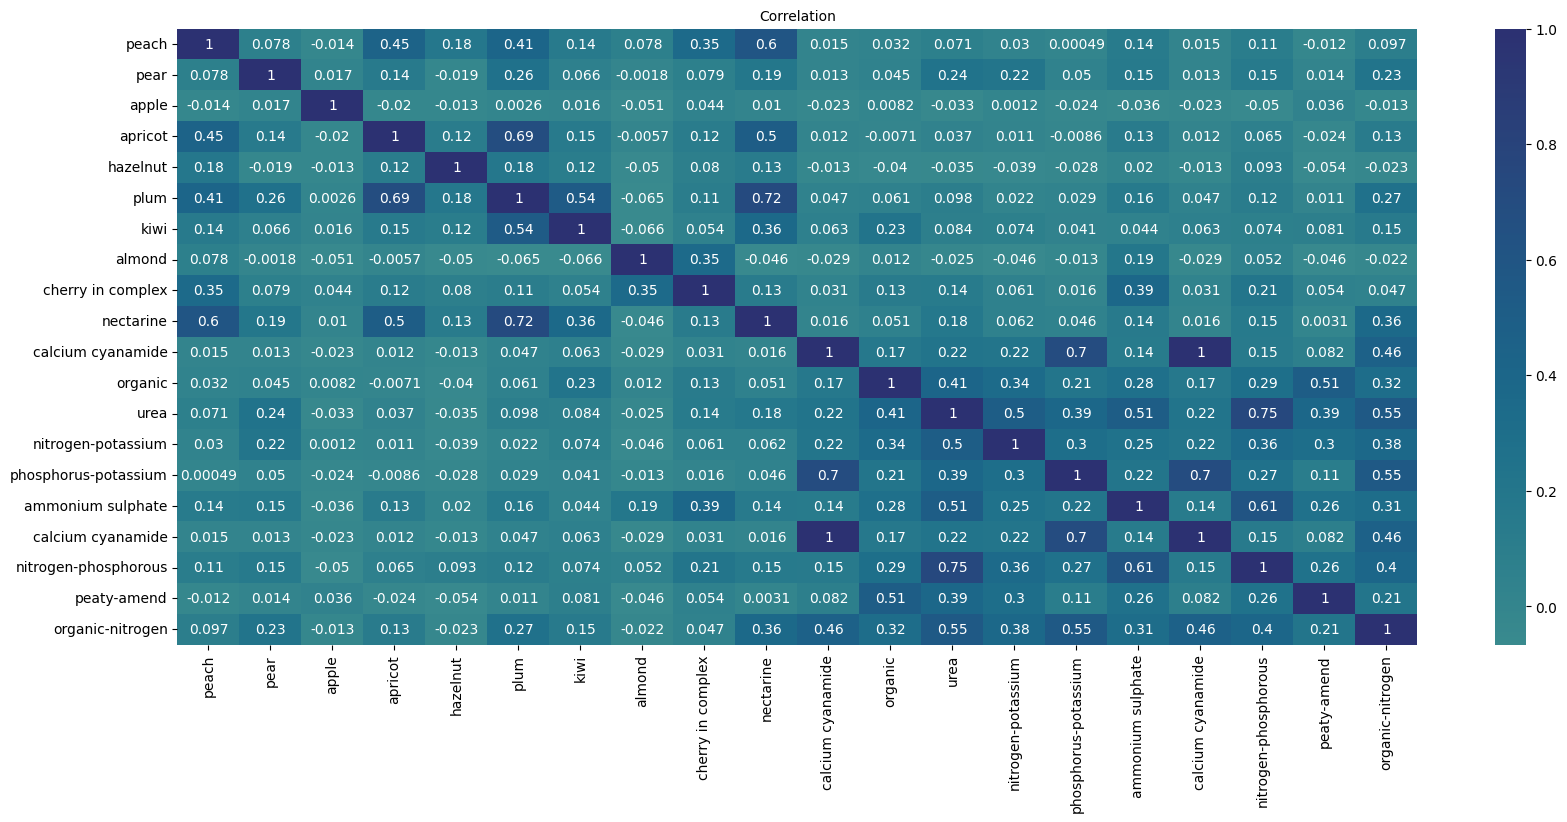

In [63]:
plt.figure(figsize=(20,8))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of fruits & nuts production in Italy 2006-2020


* Apple has low correlation with fertilizers and other crops.

* Apricot has hight correlation with Plum and Nectarine.

* Cherry has hight correlation phosphorus fertilizer and Peach.

* Kiwi has hight correlation with Plum.

* Lemon has hight correlation Orange.

* Peach has hight correlation with Nectarine.

* Pear has correlation with phosphorus and potassium fertilizers.

* There is also hight correlation between phosphorus and potassium with nitrogen fertilizer.


### Calculating Variance Inflation Factor (VIF) for all given features


In [64]:
# Function to compute the VIF
def compute_vif(selected_features):
    
    y = cor_selected [selected_features]
    # the calculation of variance inflation requires a constant
    y['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Feature"] = y.columns
    vif["VIF"] = [variance_inflation_factor(y.values, i) for i in range(y.shape[1])]
    vif = vif[vif['Feature']!='intercept']
    return vif

In [65]:
# Features selection
selected_features = ['peach', 'pear', 'apple', 'apricot', 'hazelnut','plum', 
                     'kiwi','almond', 'cherry in complex','nectarine',
                     'calcium cyanamide','organic', 'urea','nitrogen-potassium',
                     'phosphorus-potassium','ammonium sulphate','calcium cyanamide', 
                     'nitrogen-phosphorous','peaty-amend','organic-nitrogen']

# compute vif 
compute_vif(selected_features).sort_values('VIF', ascending=False)

,Feature,VIF
11,calcium cyanamide,inf
10,calcium cyanamide,inf
18,calcium cyanamide,inf
17,calcium cyanamide,inf
5,plum,4.729558
13,urea,3.438948
9,nectarine,3.208288
19,nitrogen-phosphorous,2.851198
3,apricot,2.413620
15,phosphorus-potassium,2.377803


The variable Calcium-cyanamide has showed in the Variance Inflation Factor (VIF) = inf (infinity), This result shows perfect correlation and multicolinearity, the causes of this result can vary therefore for the purpose of this work  the variable will not be used in the model.  

Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html


https://www.statisticshowto.com/variance-inflation-factor/

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/